# Analysis on base of the Corona Data of the Berliner Morgenpost

In [1]:
from datetime import datetime
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as pyplot

In [2]:
CURRENT_DATA_URL='https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/data/Coronavirus.current.v2.csv'
HISTORY_DATA_URL='https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/data/Coronavirus.history.v2.csv'

In [3]:
MEAN_INCUBATION_TIME=6 #days

# see https://www.bundesregierung.de/breg-de/themen/coronavirus/coronavirus-1725960
EVENTS = {
    'KONTAKT_SPERRE_DATE':'23/3/2020',
    'BAR_CLUB_GYM_SHUTDOWN_DATE':'16/3/2020',
    'BORDERS_CLOSED_DATE':'15/3/2020',
    'ESCALATION_EVENTS_LESS_1000_DATE':'10/3/2020'
}

In [4]:
history_df = pd.read_csv(HISTORY_DATA_URL)

# Germany

In [5]:
#history_df.parent.unique()
#history_df.label.unique()

In [6]:
de_history_df = history_df.loc[history_df.parent=='Deutschland',['label','date','recovered','confirmed','deaths']]

In [7]:
de_history_df['date'] = pd.to_datetime(de_history_df['date'])
de_history_df['active'] = de_history_df['confirmed'] - (de_history_df['recovered'] + de_history_df['deaths'])

In [8]:
de_by_date = de_history_df.groupby('date').sum()

## Absolute Cases

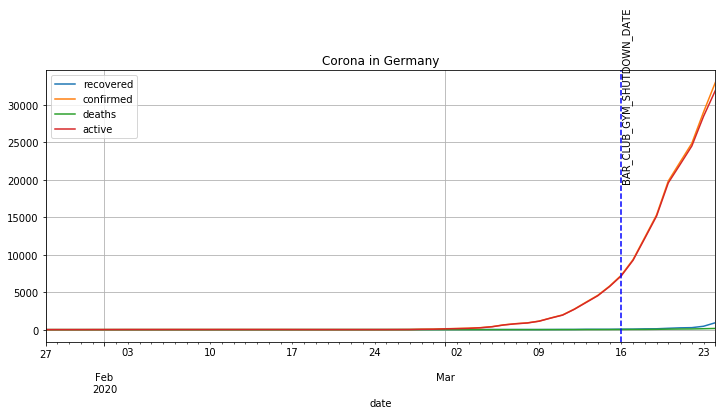

In [10]:
ax=de_by_date.plot(figsize=(12,5), title='Corona in Germany')
ax.axvline(EVENTS['BAR_CLUB_GYM_SHUTDOWN_DATE'], color="blue", linestyle="--")
pyplot.text(EVENTS['BAR_CLUB_GYM_SHUTDOWN_DATE'],20000,'BAR_CLUB_GYM_SHUTDOWN_DATE',rotation=90)
pyplot.grid(True);

## Absolute Growth

### Utilities

In [11]:
def abs_growth_from(df_by_date):
    return df_by_date.diff().fillna(0)

def plot_abs_growth(df_abs_growth,details="", max_y=None):
    max_y = max_y if max_y else df_abs_growth.max().max()
    df_abs_growth.plot(figsize=(12,4), title='Absolute Confirmed Growth (1st derivate):'+details, ylim=(0,max_y))
    pyplot.ylabel('Delta to day before');
    pyplot.grid(True)
    
def plot_abs_growth_confirmed(df_abs_growth,details=""):
    df_confirmed=df_abs_growth['confirmed']
    df = pd.DataFrame({'confirmed':df_confirmed, 'incubated':df_confirmed.shift(-MEAN_INCUBATION_TIME)})
    df.plot(figsize=(12,4), title='Absolute Growth (1st derivate):'+details)
    pyplot.ylabel('Delta to day before');
    pyplot.grid(True)    

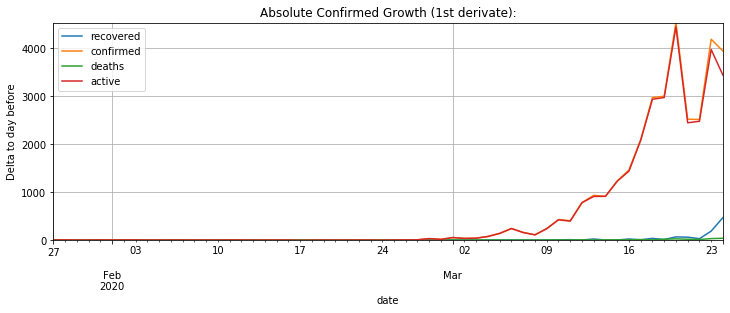

In [12]:
plot_abs_growth(abs_growth_from(de_by_date))

## Growth Factor


<img src="./growth-factor.png" width="500px">Growth Factor</img>

see [Kaggle contribution of dferhadi](https://www.kaggle.com/dferhadi/covid-19-growth-factor-visualization-and-calculus)

> the growth factor can be used to estimate the lifespan of the growth. 
> When the growth factor for the spread is 1.0 this can be a sign that we have hit the inflection point.

> ... The inflection point is where the curve changes concavity.

### Utilities

In [13]:
def growth_factor_from(confirmed_df):
    growth_confirmed = confirmed_df
    return (growth_confirmed['confirmed'] / growth_confirmed.shift(1)['confirmed'])
    
def plot_growth_factor(growth_factor_series, details=""):
    growth_factor_series.plot(figsize=(12,4), linestyle=':', linewidth=2, title='Growth Factor Confirmed (2nd derivate):' + details).axhline(y=1, color='red', linestyle='--')
    pyplot.grid(True)
    pyplot.ylabel('Deta today/Delta day before');
    pyplot.show()    

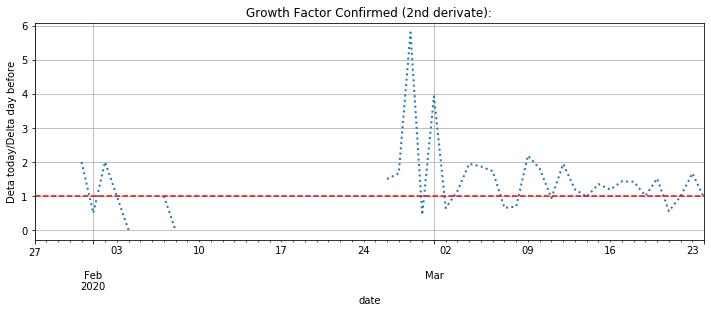

In [14]:
plot_growth_factor(growth_factor_from(abs_growth_from(de_by_date)[['confirmed']]))

# German Federal States

### Some data cleanup

In [15]:
de_fed_by_date_all = de_history_df.groupby(['date','label']).sum().reset_index()
feds = list(de_fed_by_date_all.label.unique())

feds.remove('Repatriierte')

de_fed_by_date = de_fed_by_date_all[de_fed_by_date_all.label.isin(feds)]

## Absolute Cases

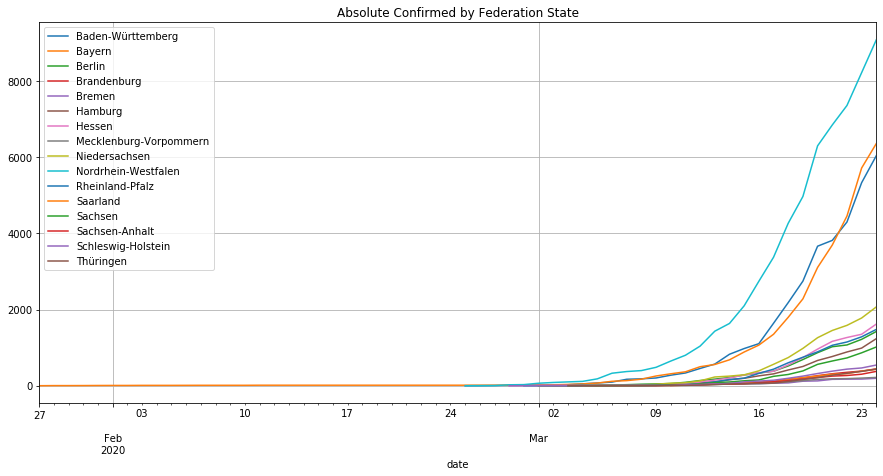

In [16]:
de_fed_by_date.set_index(['date']).groupby('label')['confirmed'].plot(figsize=(15,7), legend=True, title='Absolute Confirmed by Federation State')
pyplot.grid(True);

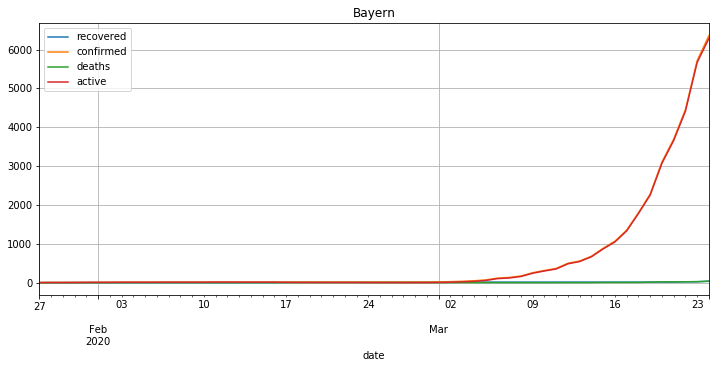

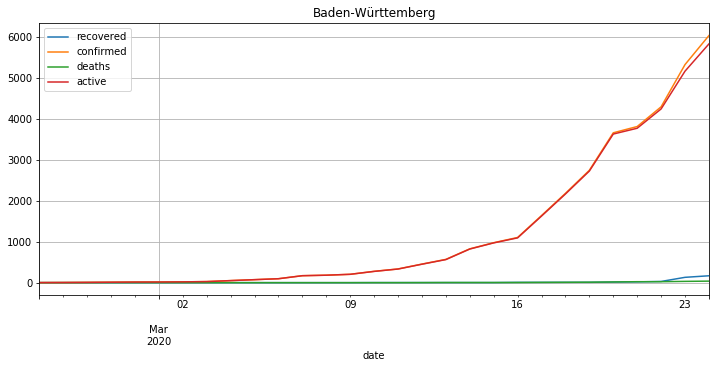

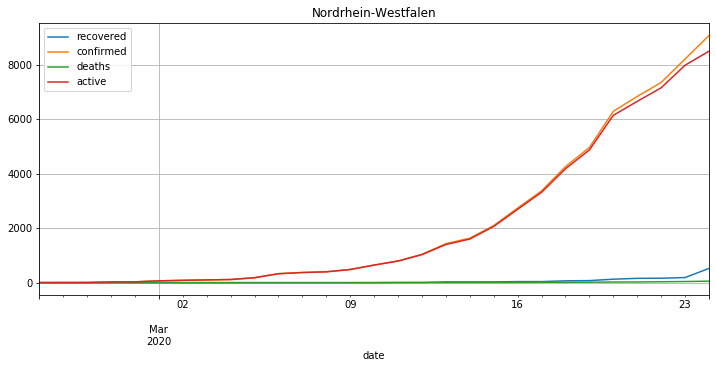

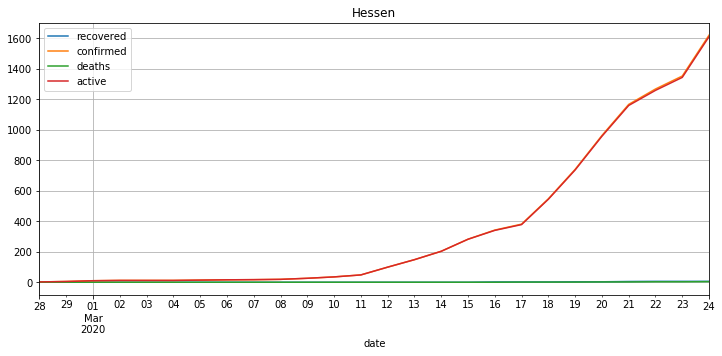

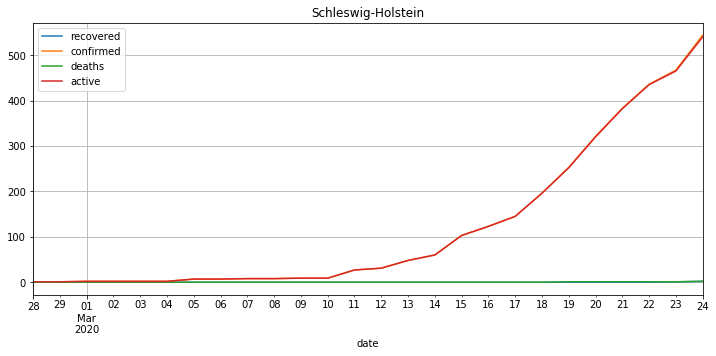

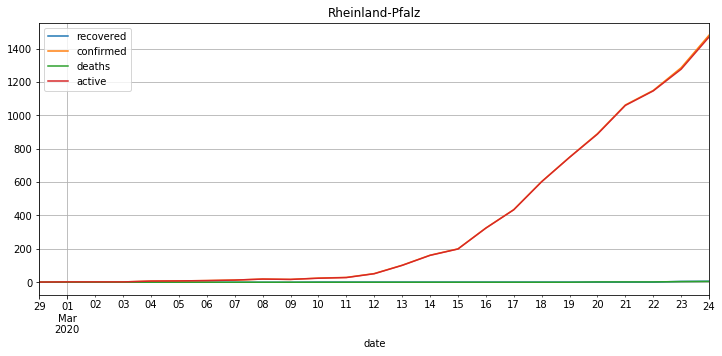

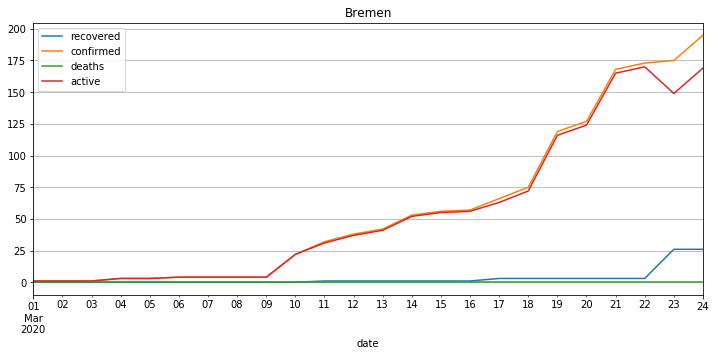

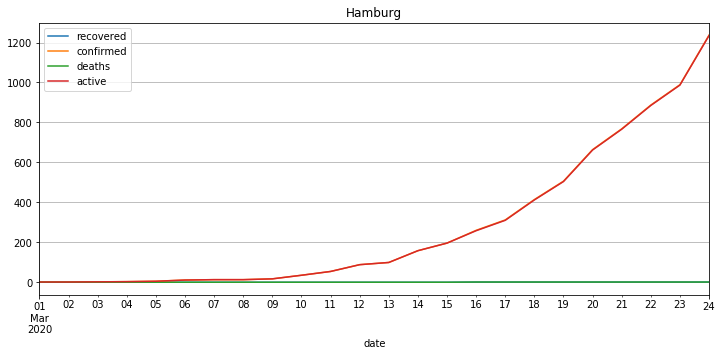

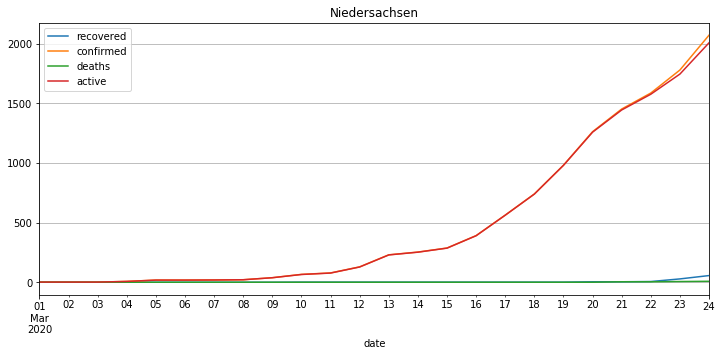

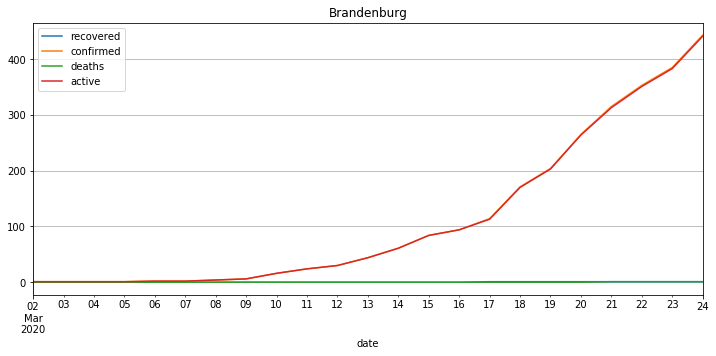

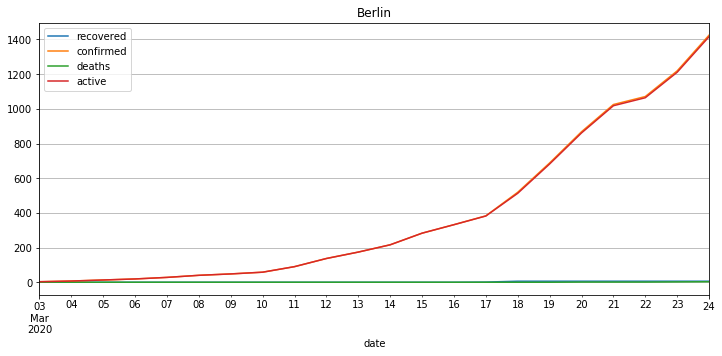

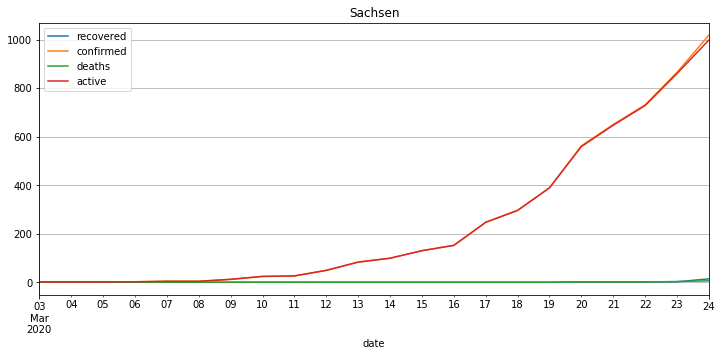

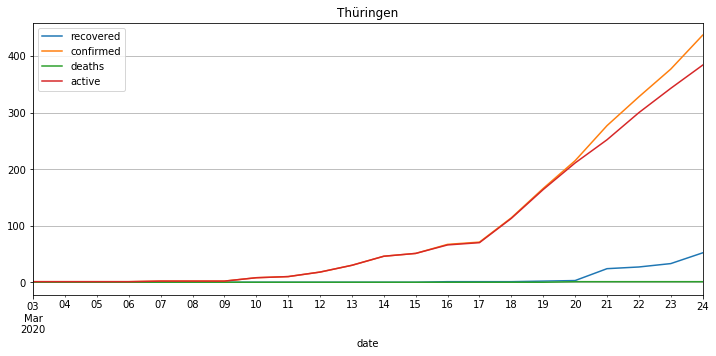

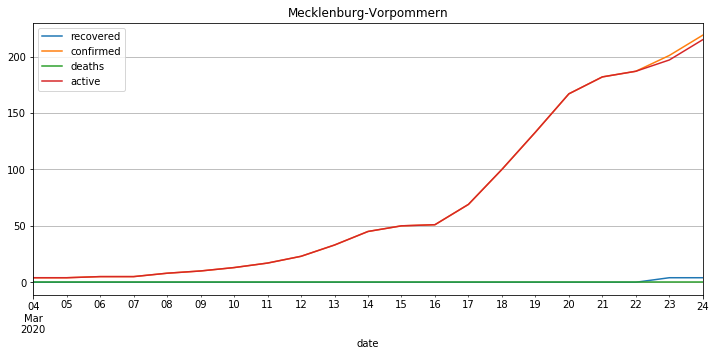

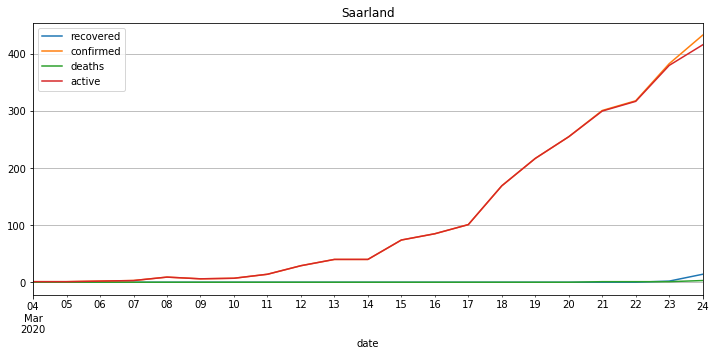

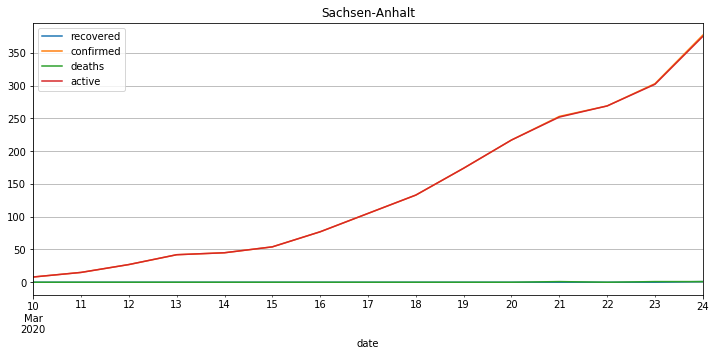

In [17]:
for fed in feds:
    de_fed_by_date.loc[de_fed_by_date.label==fed].set_index('date').plot(figsize=(12,5), title=fed)
    pyplot.grid(True)

## Absolute Growth

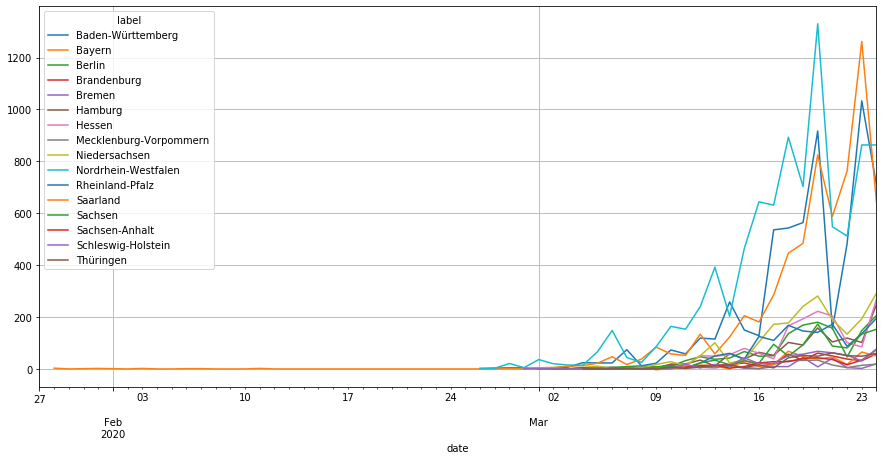

In [18]:
de_fed_by_date.set_index(['date','label'])['confirmed'].unstack().diff().plot(figsize=(15,7), legend=True)
pyplot.grid(True);

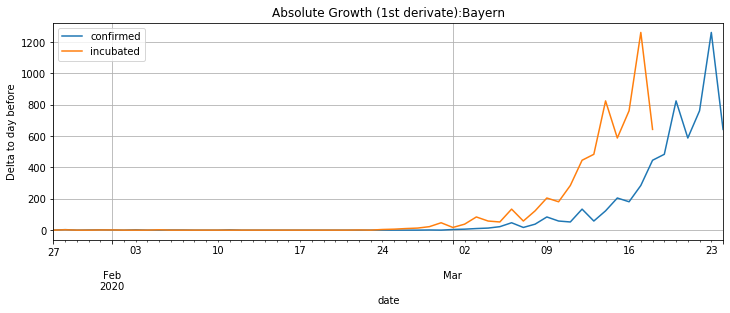

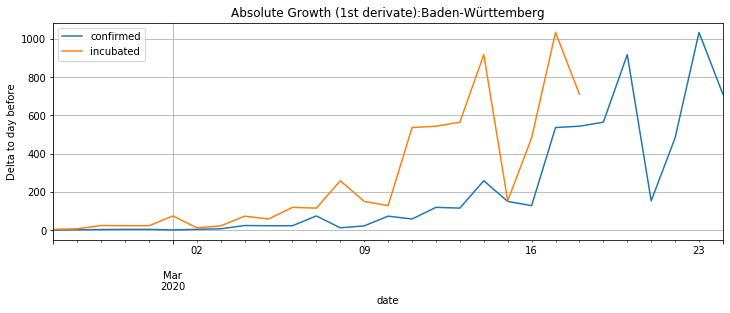

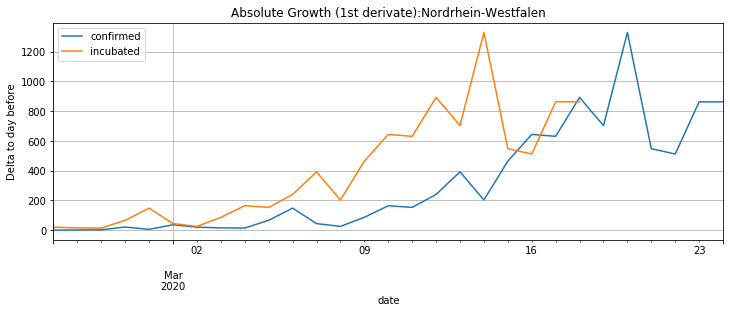

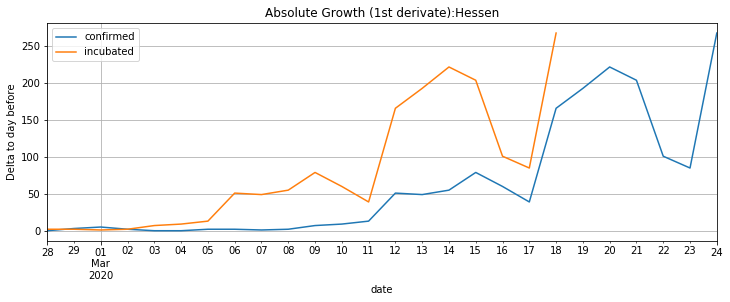

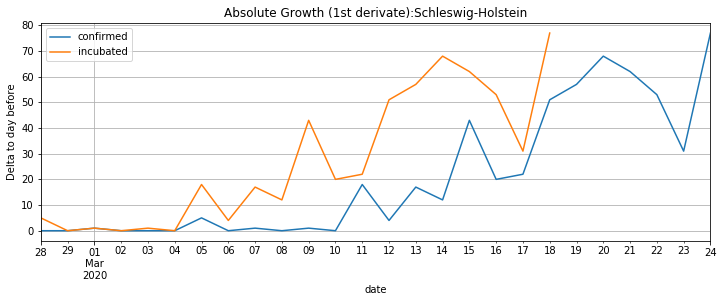

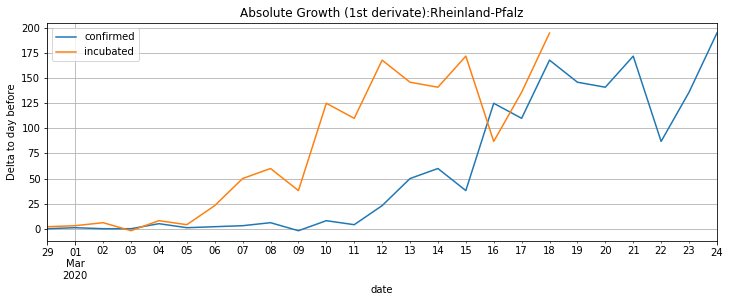

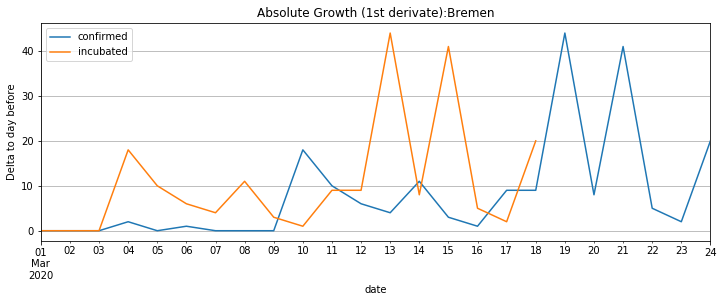

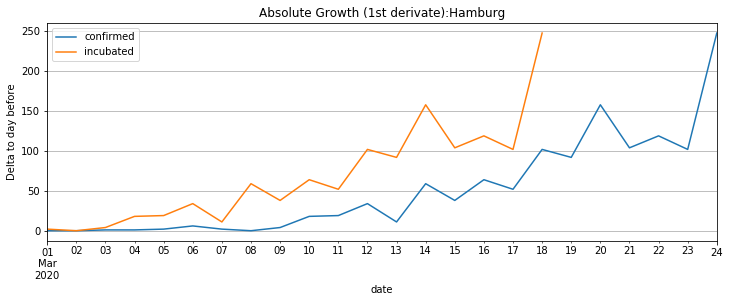

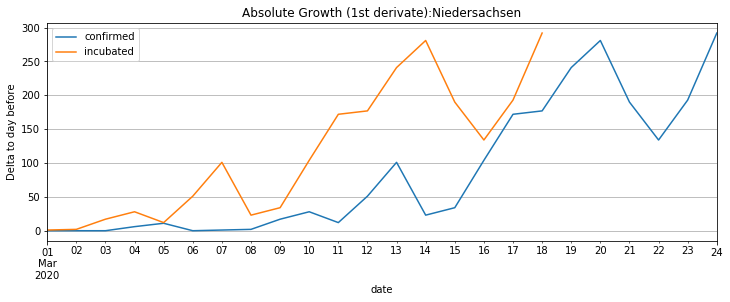

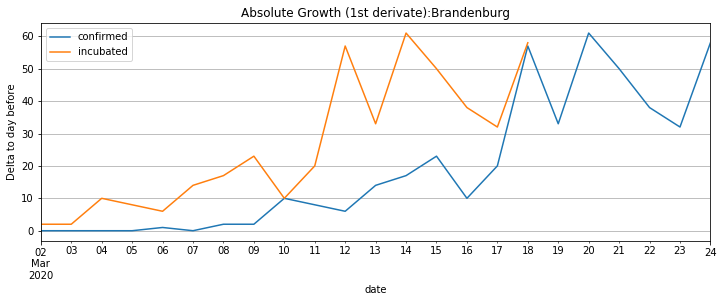

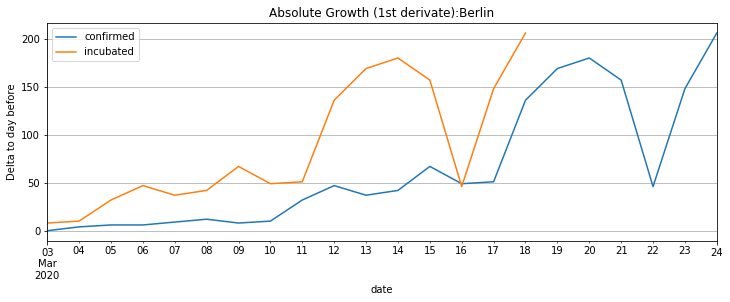

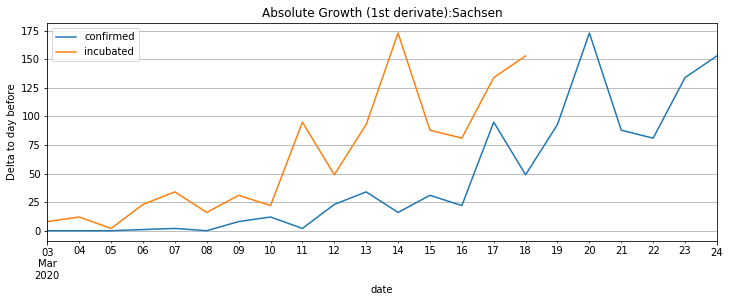

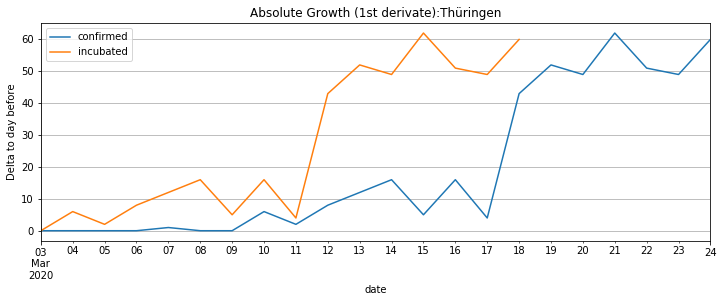

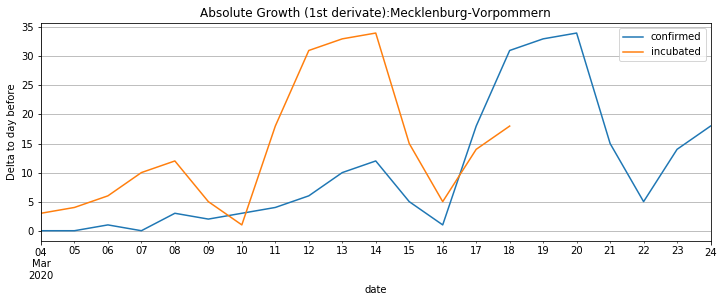

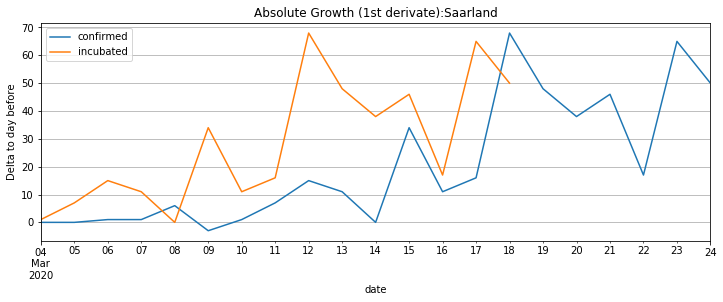

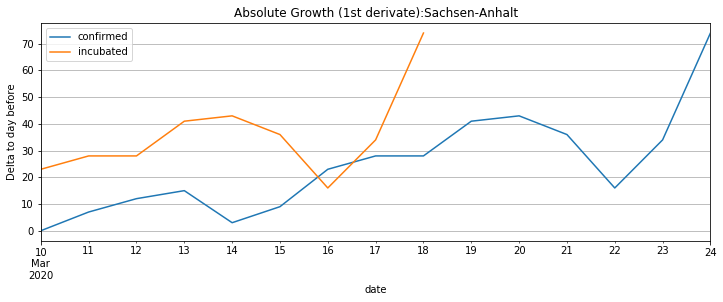

In [19]:
for fed in feds:
    fed_confirmed_by_date=de_fed_by_date.loc[de_fed_by_date.label==fed,['date','confirmed']].set_index('date')
    plot_abs_growth_confirmed(abs_growth_from(fed_confirmed_by_date), fed)    

## Growth Factor

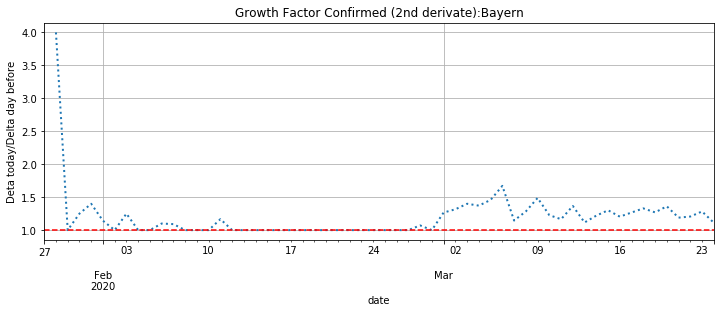

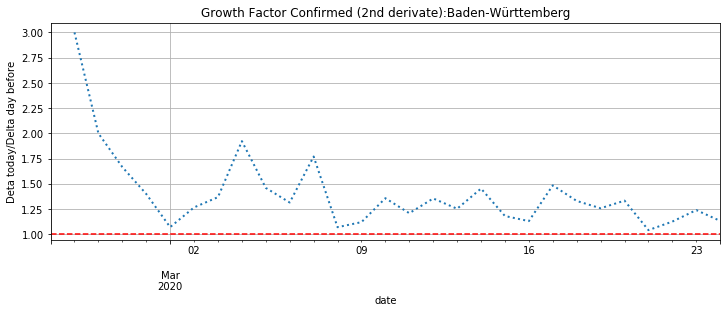

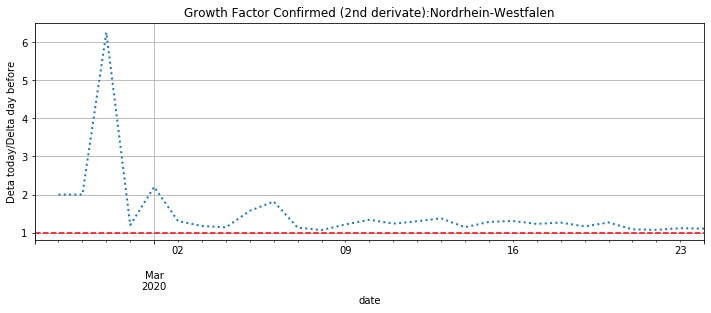

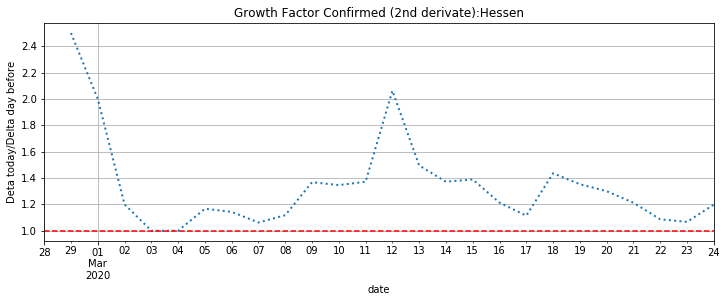

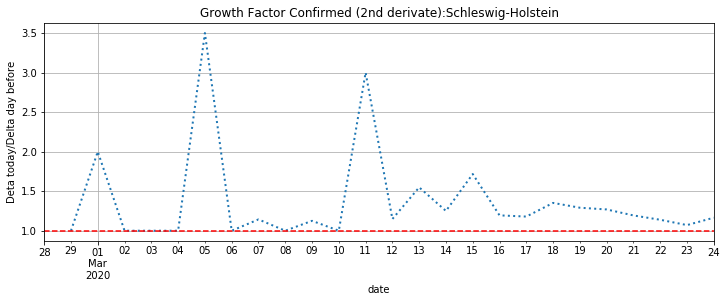

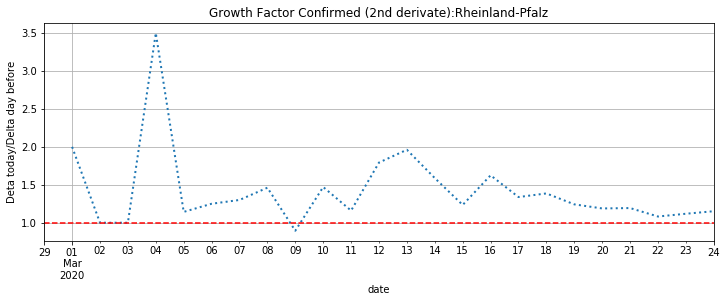

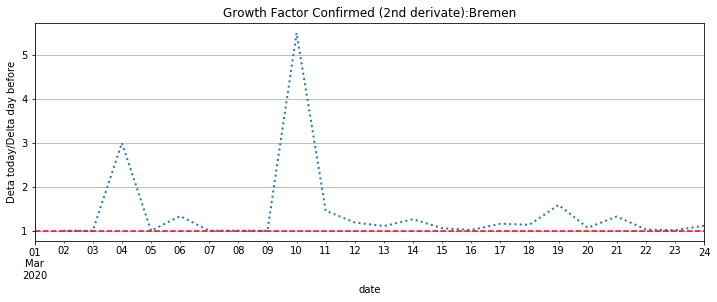

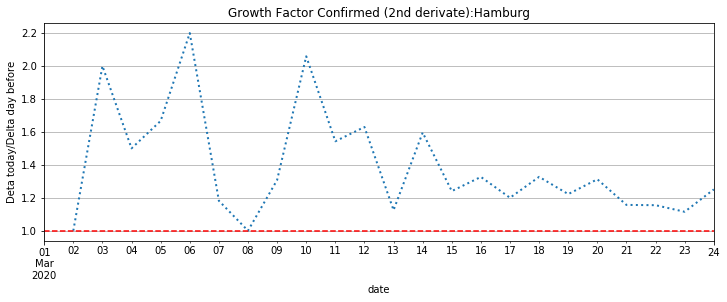

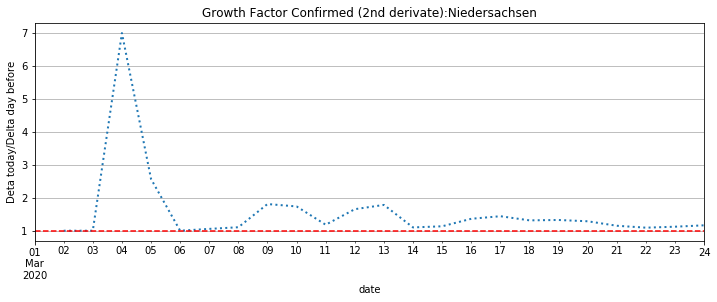

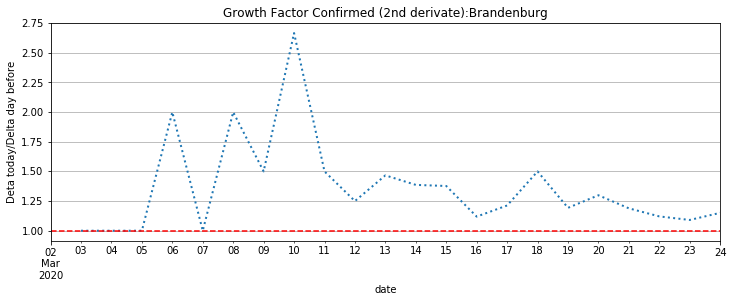

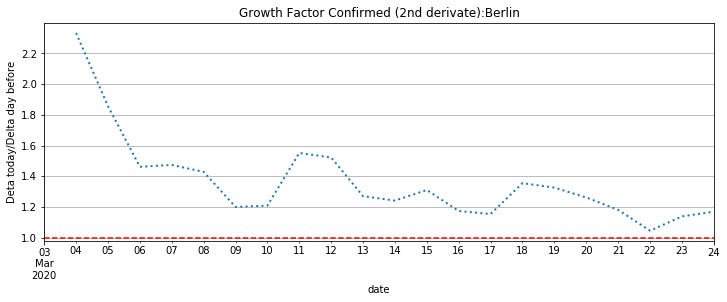

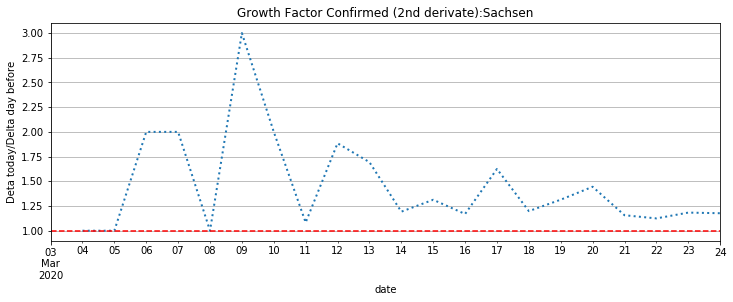

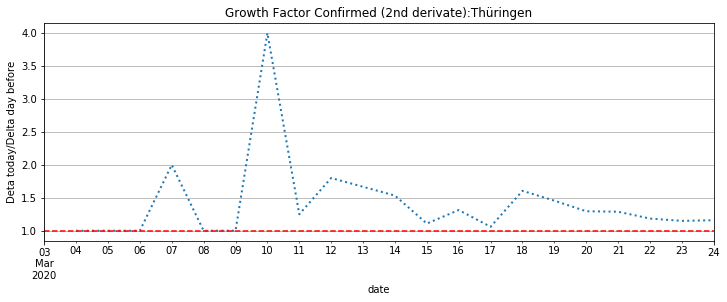

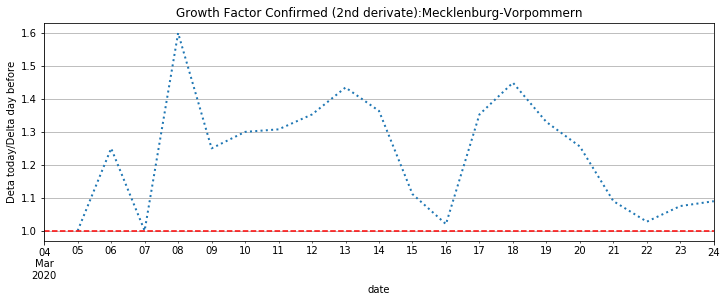

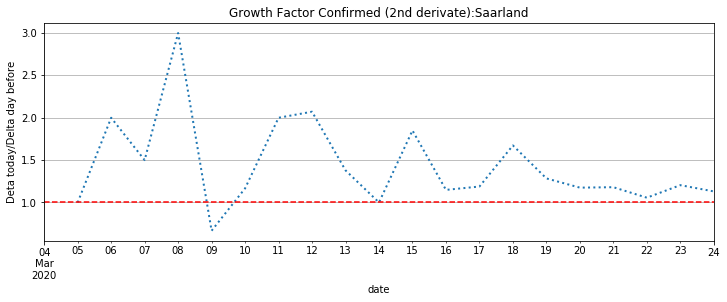

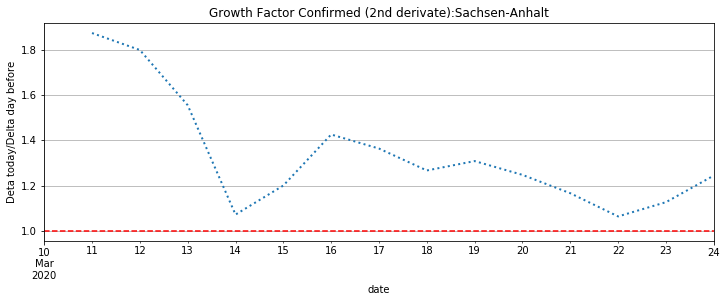

In [20]:
for fed in feds:
    fed_confirmed_by_date=de_fed_by_date.loc[de_fed_by_date.label==fed,['date','confirmed']].set_index('date')
    plot_growth_factor(growth_factor_from(fed_confirmed_by_date[['confirmed']]), fed)